<a href="https://colab.research.google.com/github/mugilan0606/Dog-Breed-Prediction/blob/main/Dog_breed_Prediction_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mugilana","key":"38b98866d226958d966d23d3b2d80455"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d jessicali9530/stanford-dogs-dataset

stanford-dogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
 mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
from zipfile import ZipFile

file = "stanford-dogs-dataset.zip"

with ZipFile(file, 'r') as zip:
  zip.extractall()
from IPython.display import clear_output
clear_output()

In [ ]:
train_data_dir = "/content/images/Images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [ ]:
def get_images(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = np.array([])                       

    for type in os.listdir(image_dir)[:50]:
        type_images = os.listdir(image_dir + type)
        labels= np.append(labels, type.split('-')[1])
        
        for image in type_images[:1]:
            image_file = os.path.join(image_dir, type + '/', image)
            image_data = mpimg.imread(image_file)
            image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
            images[image_index, :] = image_resized.flatten()
            print (type, ':', image)
            image_index += 1

    return (images, labels)


In [ ]:
def plot_images(instances, images_per_row=10, **options):
    size = img_width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((img_width, img_height * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(20,20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('dogs_images.png', transparent= True, bbox_inches= 'tight', dpi= 900)
    plt.show()

n02102318-cocker_spaniel : n02102318_11648.jpg
n02113978-Mexican_hairless : n02113978_573.jpg
n02115641-dingo : n02115641_6407.jpg
n02088364-beagle : n02088364_852.jpg
n02088466-bloodhound : n02088466_12353.jpg
n02108551-Tibetan_mastiff : n02108551_2921.jpg
n02094433-Yorkshire_terrier : n02094433_8580.jpg
n02102480-Sussex_spaniel : n02102480_3685.jpg
n02094114-Norfolk_terrier : n02094114_347.jpg
n02089973-English_foxhound : n02089973_504.jpg
n02106166-Border_collie : n02106166_6415.jpg
n02093754-Border_terrier : n02093754_897.jpg
n02111277-Newfoundland : n02111277_13845.jpg
n02107142-Doberman : n02107142_814.jpg
n02111129-Leonberg : n02111129_593.jpg
n02102040-English_springer : n02102040_7195.jpg
n02102177-Welsh_springer_spaniel : n02102177_2447.jpg
n02111500-Great_Pyrenees : n02111500_7983.jpg
n02104365-schipperke : n02104365_4190.jpg
n02101006-Gordon_setter : n02101006_134.jpg
n02087046-toy_terrier : n02087046_7293.jpg
n02091244-Ibizan_hound : n02091244_486.jpg
n02091467-Norwegian_e

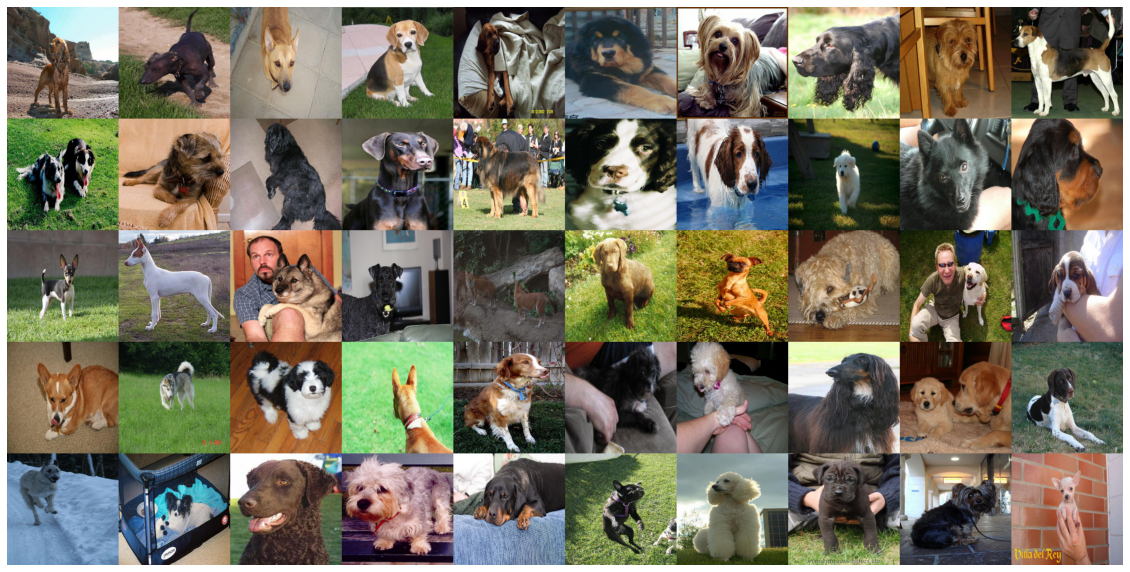

In [ ]:
images,labels= get_images(train_data_dir)
plot_images(images)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [ ]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [ ]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

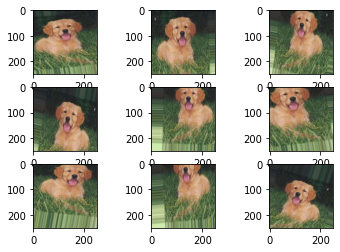

In [ ]:
img = load_img('/content/images/Images/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [ ]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
history = model.fit(
    train_generator, 
    epochs = 20,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.71320, saving model to baseline_model.h5
257/257 - 336s - loss: 3.4003 - accuracy: 0.2872 - val_loss: 1.7132 - val_accuracy: 0.6811 - lr: 1.0000e-04 - 336s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_loss improved from 1.71320 to 0.98425, saving model to baseline_model.h5
257/257 - 308s - loss: 1.5980 - accuracy: 0.6294 - val_loss: 0.9842 - val_accuracy: 0.7604 - lr: 1.0000e-04 - 308s/epoch - 1s/step
Epoch 3/20

Epoch 3: val_loss improved from 0.98425 to 0.80512, saving model to baseline_model.h5
257/257 - 289s - loss: 1.1788 - accuracy: 0.6925 - val_loss: 0.8051 - val_accuracy: 0.7793 - lr: 1.0000e-04 - 289s/epoch - 1s/step
Epoch 4/20

Epoch 4: val_loss improved from 0.80512 to 0.74119, saving model to baseline_model.h5
257/257 - 291s - loss: 1.0519 - accuracy: 0.7135 - val_loss: 0.7412 - val_accuracy: 0.7887 - lr: 1.0000e-04 - 291s/epoch - 1s/step
Epoch 5/20

Epoch 5: val_loss improved from 0.74119 to 0.70812, saving model to baseline

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 [==============================] - 27s 424ms/step - loss: 0.6411 - accuracy: 0.8097
Validation Loss:  0.6411164402961731
Validation Accuracy:  0.8096758127212524


In [ ]:
import pickle
with open('dog_model_pkl', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://5dc0d678-a993-4164-aae8-316aeee66157/assets


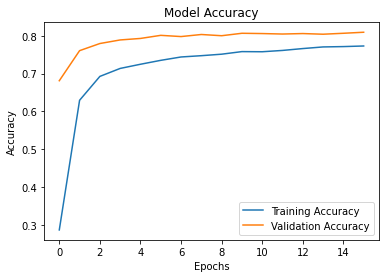

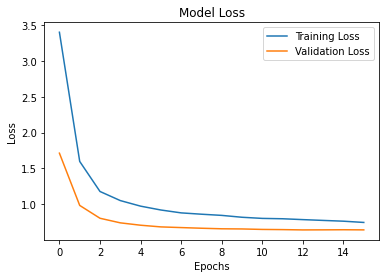

In [ ]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()